<a href="https://colab.research.google.com/github/MihaiDogariu/CV3/blob/main/laborator/CV%203%20-%20Lab%20%236.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
# se importa bibliotecile utilizate
!pip install -U kora
%matplotlib inline
import matplotlib.pyplot as plt 
import torch
import torchvision.transforms as T
import torchvision
import numpy as np
import cv2
import warnings
warnings.filterwarnings('ignore')

from kora.drive import upload_public
from IPython.display import HTML
from PIL import Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Biblioteca `torchvision` pune la dispozitie o serie de modele pre-antrenate, ce pot fi utilizate fara a mai fi nevoie de o antrenare noua. Pentru acest laborator se selecteaza unul dintre [aceste](https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection) modele. Pentru moment, se ignora tipul modelului (metoda, backbone, clasificator, etc.), atentia punandu-se pe rezultatul oferit de detector si procesarea lui.

In [ ]:
# se descarca modelul pre-antrenat: Faster R-CNN cu backbone ResNet-50 si Feature Pyramid Network
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# se seteaza modelul in starea de evaluare/inferenta - acest atribut schimba comportamentul unor straturi fata de modul in care se comporta in timpul antrenarii, e.g. batch normalization
model.eval()


# se incarca lista de etichete a bazei de date MS-COCO
COCO_INSTANCE_CATEGORY_NAMES = [
    'bg', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [ ]:
# functie de detectie: citeste o imagine, o pre-proceseaza, o propaga prin model si intoarce rezultatele detectiei
def get_prediction(img_path, confidence_threshold):
  img = Image.open(img_path) # se deschide imaginea folosind calea sa absoluta ca argument
  transform = T.Compose([T.ToTensor()]) # se creeaza un set de transformari pe care le vom aplica fiecarei imagini citite - in acest caz, este suficienta doar transformarea imaginii in tensor
  img = transform(img) # se aplica transformarea pe imaginea deschisa
  pred = model([img]) # se propaga imaginea prin modelul de detectie
                      # pentru fiecare imagine din lista de intrare se returneaza un dictionar care contine:
                      # 1. lista de casete de incadrare
                      # 2. lista de clase detectate
                      # 3. lista de scoruri (confidence score) asociate detectiilor
                      # detectiile sunt plasate in lista de iesire in ordinea descrescatoare a scorului de detectie
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # se transforma lista de clase numerice detectate in lista de cuvinte asociate claselor conform bazei MS-COCO
  pred_boxes = [[int(i[0]), int(i[1]), int(i[2]), int(i[3])] for i in list(pred[0]['boxes'].detach().numpy())]  # se extrag casetele de incadrare 
                                                                                                                    # fiecare coordonata trebuie transformata manual in data de tipul int, deoarece, 
                                                                                                                    # in urma regresiei casetelor de incadrare, coordonatele sunt calculate ca valori reale
  pred_score = list(pred[0]['scores'].detach().numpy()) # se extrag scorurile de detectie
  pred_t = [pred_score.index(x) for x in pred_score if x>confidence_threshold][-1] # se selecteaza indecsii detectiilor al caror scor depaseste pragul impus
  pred_boxes = pred_boxes[:pred_t+1] # se selecteaza doar casetele de incadrare ale obiectelor al caror scor depaseste pragul impus
  pred_class = pred_class[:pred_t+1] # se selecteaza doar clasele obiectelor al caror scor depaseste pragul impus
  pred_score = pred_score[:pred_t+1] # se selecteaza doar scorurile obiectelor care depasesc pragul impus
  return pred_boxes, pred_class, pred_score

In [ ]:
# functie care apeleaza functia de detectie pentru o imagine si afiseaza rezultatele
def detect_object(img_path, confidence=0.5, rect_th=2, text_size=0.5, text_th=1):
  boxes, pred_cls, score = get_prediction(img_path, confidence) # rularea detectiei
  # afisarea rezultatelor pe imaginea originala:
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(boxes)):
    cv2.rectangle(img, (boxes[i][0], boxes[i][1]), (boxes[i][2], boxes[i][3]), color=(0, 255, 0), thickness=rect_th) # afisarea casetei de incadrare
    cv2.putText(img,"{}:{:.2f}".format(pred_cls[i], score[i]), (boxes[i][0], boxes[i][1]-6), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # afisarea clasei si a scorului pentru fiecare caseta
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Exemplu de detectie pe o imagine aleatoare:

2022-11-24 15:07:23 URL:https://www.goodfreephotos.com/cache/other-photos/car-and-traffic-on-the-road-coming-towards-me_800.jpg?cached=1522560655 [409997/409997] -> "traffic.jpg" [1]


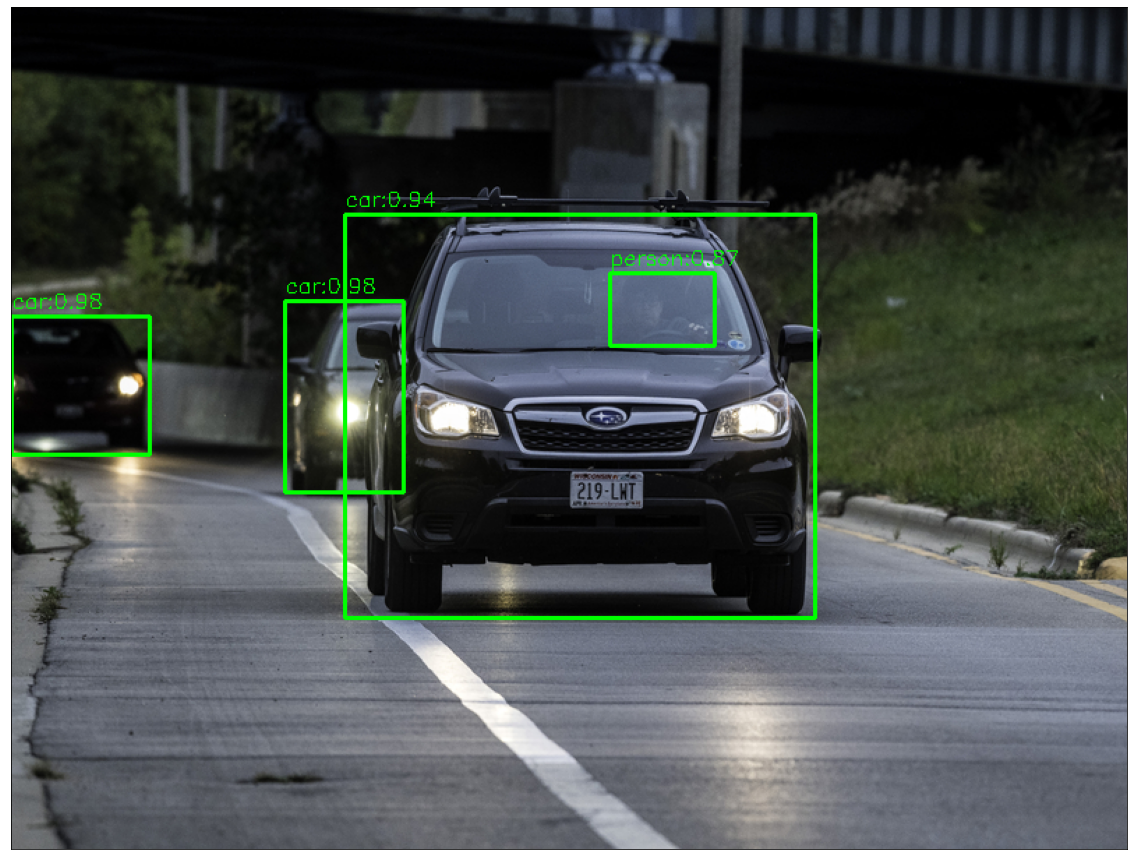

In [99]:
!wget -nv https://www.goodfreephotos.com/cache/other-photos/car-and-traffic-on-the-road-coming-towards-me.jpg -O traffic.jpg
detect_object('traffic.jpg', confidence=0.7)

#TODO:
Aplicatia #1: folosirea detectorului de obiecte pentru a detecta bagaje abandonate din imagini preluate de camere de supraveghere

Aplicatia #2: rularea detectorului de obiecte pe o secventa video

Descarcarea resurselor - acest bloc este preferabil sa fie rulat o singura data.

In [95]:
# Secvente video:
!wget -O video1.mp4 --no-check-certificate "https://docs.google.com/uc?export=download&id=1STE6xpyG3-U_xCBzsMgnD6_r-DMlAS5c"
!wget -O video2.mp4 --no-check-certificate "https://docs.google.com/uc?export=download&id=1y8lQqtPBbBrn_UjGwbEGn8gBybWNaNPY"
!wget -O video3.mp4 --no-check-certificate "https://docs.google.com/uc?export=download&id=1mzy4v0rkSTfXucQbZP7t1J6uemEygFRo"

# Imagini:
!wget -O img1.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1SrWV4NMGBy6cYhRvvlIjAxyKfqfIrWow"
!wget -O img2.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1bM3i5_ypub7XDJX4z8m7JO59XJAEVZdI"
!wget -O img3.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1kf8UJECW15tSesdgybeXAhjRBrju9ERH"
!wget -O img4.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1LhqNqYHjnxSB9e3O2TSEfV30kmk3-Qrp"
!wget -O img5.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=11ZtCTGOtB_j99cjreaRgpszvXvkRdIPW"

!ls -al

--2022-11-24 15:03:30--  https://docs.google.com/uc?export=download&id=1STE6xpyG3-U_xCBzsMgnD6_r-DMlAS5c
Resolving docs.google.com (docs.google.com)... 142.251.16.101, 142.251.16.102, 142.251.16.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.16.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b0t1lr273bqd2v32du5j72vushq3ei8n/1669302150000/15898984732338629394/*/1STE6xpyG3-U_xCBzsMgnD6_r-DMlAS5c?e=download&uuid=dd7b05af-7129-4e23-b950-01589139570f [following]
--2022-11-24 15:03:33--  https://doc-10-1o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b0t1lr273bqd2v32du5j72vushq3ei8n/1669302150000/15898984732338629394/*/1STE6xpyG3-U_xCBzsMgnD6_r-DMlAS5c?e=download&uuid=dd7b05af-7129-4e23-b950-01589139570f
Resolving doc-10-1o-docs.googleusercontent.com (doc-10-1o-docs.googleusercontent.com)... 172.253.122.132, 2607:f8b0

#TODO #1
Aplicatia #1: Detectia bagajelor abandonate

Sa se implementeze un sistem simplificat de detectie a bagajelor abandonate. Acesta trebuie sa emita un mesaj de avertizare (o alarma) atunci cand in imagine este detectat un bagaj abandonat.


*   Prin bagaj intelegem orice obiect din clasa "backpack", "suitcase" sau 
"handbag".
*   Prin bagaj abandonat intelegem orice bagaj care nu se afla in posesia unei persoane. Consideram ca un bagaj se afla in posesia unei persoane atunci cand caseta de incadrare a bagajului se intersecteaza cu caseta de incadrare a cel putin unei persoane.

Se va inconjura cu un chenar rosu fiecare bagaj considerat abandonat. Celelalte bagaje se vor inconjura cu un chenar de alta culoare.

#TODO #2
Aplicatia #2: Detectia obiectelor intr-un fisier video

Sa se ruleze detectia tuturor obiectelor dintr-un fisier video. Acest lucru presupune 3 pasi:
1. Transformarea unui fisier video in secventa de cadre;
2. Rularea detectiei de obiecte pe fiecare cadru, in parte;
3. Transformarea secventei de cadre prelucrate intr-o secventa video si afisarea ei.

In [100]:
# pentru a afisa o secventa video in mediul Google Colab se poate folosi codul de mai jos
url = upload_public('./video1.mp4')
HTML(f"""<video src={url} width=500 controls/>""")